### CREDIT

This notebook is prepared by the guidance of Shivam Chandhok's blogs from Pyimagesearch. Most of the code blocks and explanations are taken from these blogs. You can reach original codes and detailed explanations from references.

#### WHAT IS THIS NOTEBOOK

This notebook is an example about CycleGAN by keras and TF. We will implement CycleGAN for Image Translation for Unpaired Image-to-Image Translation on Apples-to-Oranges Dataset


#### Keywords

* CycleGAN
* Image-to-Image Translation
* GAN
* TF 
* Apples-to-Oranges Dataset

In [1]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras import Input
import tensorflow as tf
import os

import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define configurations...

In [2]:
# define the batch size for training and inference
class Config:
    TRAIN_BATCH_SIZE = 1
    INFER_BATCH_SIZE = 8

    # dataset specs
    IMG_WIDTH = 256
    IMG_HEIGHT = 256
    IMG_CHANNELS = 3

    # training specs
    LR = 2e-4
    EPOCHS = 50
    STEPS_PER_EPOCH = 800

    # path to the base output directory
    BASE_OUTPUT_PATH = "outputs"

    # path to the cycle gan generator
    GENERATOR_MODEL = os.path.join(BASE_OUTPUT_PATH, "models",
        "generator")

    # path to the inferred images and to the grid image
    BASE_IMAGES_PATH = os.path.join(BASE_OUTPUT_PATH, "images")
    GRID_IMAGE_PATH = os.path.join(BASE_IMAGES_PATH, "grid.png")

config = Config()

In [3]:
def preprocess_image(image):
    # convert both images to float32 tensors and
    # convert pixels to the range of -1 and 1
    image = tf.cast(image, tf.float32) / 127.5 - 1

    # return the image
    return (image)

def random_jitter(image):
    # upscale the image and randomly crop them
    image = tf.image.resize(image, [286, 286],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    cropped = tf.image.random_crop(image, size=[256, 256, 3])

    # randomly flip the cropped image
    image = tf.image.random_flip_left_right(cropped)

    # return the image
    return image

def read_train_example(data):
    # pre-process the image
    image = preprocess_image(data["image"])
    image = random_jitter(image)

    # reshape the input image
    image = tf.image.resize(image, [256, 256])

    # return the input image
    return (image)

def read_test_example(data):
    # pre-process the image and resize it
    image = preprocess_image(data["image"])
    image = tf.image.resize(image, [256, 256])

    # return the image
    return (image)

In [4]:
# define the module level autotune
AUTO = tf.data.AUTOTUNE

# downloading the apple to orange dataset using tensorflow datasets
print("[INFO] downloading the apple 2 orange dataset...")
dataset = tfds.load("cycle_gan/apple2orange")
(trainInput, trainOutput)= (dataset["trainA"], dataset["trainB"]) 



[INFO] downloading the apple 2 orange dataset...


Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|          | 0/74 [00:01<?, ? MiB/s]

Extraction completed...: 0 file [00:01, ? file/s]
Dl Size...:   1%|▏         | 1/74 [00:02<02:51,  2.34s/ MiB]

Extraction completed...: 0 file [00:02, ? file/s]
Dl Size...:   3%|▎         | 2/74 [00:03<01:37,  1.35s/ MiB]

Extraction completed...: 0 file [00:03, ? file/s]
Dl Size...:   4%|▍         | 3/74 [00:03<01:10,  1.00 MiB/s]

Extraction completed...: 0 file [00:03, ? file/s]
Dl Size...:   5%|▌         | 4/74 [00:04<00:57,  1.22 MiB/s]

Extraction completed...: 0 file [00:04, ? file/s]
Dl Size...:   7%|▋         | 5/74 [00:04<00:47,  1.44 MiB/s]

Extraction completed...: 0 file [00:04, ? file/s]
Dl Size...:   8%|▊         | 6/74 [00:05<00:44,  1.53 MiB/s]

Extraction completed...: 0 file [00:05, ? file/s]
Dl Size...:   9%|▉         | 7/74 [00:05<00:39,  1.68 M

Dl Size...:  58%|█████▊    | 43/74 [00:21<00:18,  1.68 MiB/s]

Extraction completed...: 0 file [00:21, ? file/s]
Dl Size...:  59%|█████▉    | 44/74 [00:21<00:15,  1.92 MiB/s]

Extraction completed...: 0 file [00:21, ? file/s]
Dl Size...:  61%|██████    | 45/74 [00:22<00:14,  2.07 MiB/s]

Extraction completed...: 0 file [00:22, ? file/s]
Dl Size...:  62%|██████▏   | 46/74 [00:22<00:15,  1.86 MiB/s]

Extraction completed...: 0 file [00:22, ? file/s]
Dl Size...:  64%|██████▎   | 47/74 [00:23<00:13,  2.00 MiB/s]

Extraction completed...: 0 file [00:23, ? file/s]
Dl Size...:  65%|██████▍   | 48/74 [00:23<00:11,  2.21 MiB/s]

Extraction completed...: 0 file [00:23, ? file/s]
Dl Size...:  66%|██████▌   | 49/74 [00:23<00:10,  2.47 MiB/s]

Extraction completed...: 0 file [00:23, ? file/s]
Dl Size...:  68%|██████▊   | 50/74 [00:24<00:08,  2.75 MiB/s]

Extraction completed...: 0 file [00:24, ? file/s]
Dl Size...:  69%|██████▉   | 51/74 [00:24<00:10,  2.23 MiB/s]

Extraction completed...: 0 file [

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:32<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:33<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:34<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:35<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:36<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:37<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:38<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:39<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:40<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:41<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:42<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:43<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:44<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:45<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Extraction completed...:   4%|▍         | 111/2528 [00:46<10:31,  3.83 file/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:46<00:00,  3.33 MiB/s]

Extraction completed...:   9%|▉         | 229/2528 [00:46<01:31, 25.22 file/s]

Dl Size...: 100%|██████████| 74/74 [00

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Extraction completed...:  11%|█         | 277/2528 [00:47<00:47, 47.42 file/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Extraction completed...:  13%|█▎        | 323/2528 [00:47<00:27, 78.78 file/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:47<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Extraction completed...:  20%|█▉        | 493/2528 [00:

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Extraction completed...:  21%|██▏       | 541/2528 [00:48<00:09, 206.51 file/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [0

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Extraction completed...:  23%|██▎       | 591/2528 [00:48<00:08, 225.12 file/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [0

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Extraction completed...:  25%|██▌       | 641/2528 [00:48<00:08, 233.30 file/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [0

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Extraction completed...:  27%|██▋       | 689/2528 [00:48<00:09, 202.73 file/s]

Dl Size...: 100%|██████████| 74/74 [00:48<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:49<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [0

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Extraction completed...:  52%|█████▏    | 1314/2528 [00:52<00:06, 191.82 file/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Extraction completed...:  56%|█████▋    | 1422/2528 [00:52<00:05, 207.42 file/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:52<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Extraction completed...:  63%|██████▎   | 1583/2528 [00:53<00:04, 206.33 file/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Extraction completed...:  64%|██████▍   | 1626/2528 [00:53<00:04, 201.73 file/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:53<00:00,  3.33 MiB/s]

Extraction completed...:  67%|██████▋   | 1691/2528 [00:53<00:04, 186.93 file/s]

Dl Size...: 100%|██████████| 74/74 [

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Extraction completed...:  69%|██████▊   | 1734/2528 [00:54<00:04, 194.13 file/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:54<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Extraction completed...:  77%|███████▋  | 1945/2528 [00:55<00:02, 214.91 file/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Extraction completed...:  79%|███████▉  | 1992/2528 [00:55<00:02, 209.81 file/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:55<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Extraction completed...:  83%|████████▎ | 2105/2528 [00:56<00:02, 201.72 file/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Extraction completed...:  85%|████████▌ | 2152/2528 [00:56<00:01, 200.00 file/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [00:56<00:00,  3.33 MiB/s]

Dl Size...: 100%|██████████| 74/74 [

Generating trainA examples...: 230 examples [00:01, 146.34 examples/s]
Generating trainA examples...: 245 examples [00:01, 147.08 examples/s]
Generating trainA examples...: 261 examples [00:01, 149.23 examples/s]
Generating trainA examples...: 278 examples [00:01, 153.17 examples/s]
Generating trainA examples...: 295 examples [00:01, 156.37 examples/s]
Generating trainA examples...: 311 examples [00:02, 150.97 examples/s]
Generating trainA examples...: 327 examples [00:02, 144.60 examples/s]
Generating trainA examples...: 342 examples [00:02, 141.13 examples/s]
Generating trainA examples...: 357 examples [00:02, 142.90 examples/s]
Generating trainA examples...: 373 examples [00:02, 145.38 examples/s]
Generating trainA examples...: 389 examples [00:02, 148.39 examples/s]
Generating trainA examples...: 406 examples [00:02, 152.10 examples/s]
Generating trainA examples...: 422 examples [00:02, 151.45 examples/s]
Generating trainA examples...: 439 examples [00:02, 156.00 examples/s]
Genera

Generating trainB examples...: 951 examples [00:06, 193.19 examples/s]
Generating trainB examples...: 975 examples [00:06, 204.25 examples/s]
Generating trainB examples...: 998 examples [00:06, 207.72 examples/s]
Generating trainB examples...: 1019 examples [00:06, 193.49 examples/s]
                                                                       
Shuffling C:\Users\Zeki\tensorflow_datasets\cycle_gan\apple2orange\2.0.0.incompleteJ7R5UO\cycle_gan-trainB.tfrecord*...:   0%|          | 0/1019 [00:00<?, ? examples/s]
Generating splits...:  50%|█████     | 2/4 [00:13<00:13,  6.69s/ splits]                                                                                                
Generating testA examples...: 0 examples [00:00, ? examples/s]
Generating testA examples...: 21 examples [00:00, 202.47 examples/s]
Generating testA examples...: 42 examples [00:00, 195.82 examples/s]
Generating testA examples...: 63 examples [00:00, 200.53 examples/s]
Generating testA examples...: 87 ex

Dataset cycle_gan downloaded and prepared to C:\Users\Zeki\tensorflow_datasets\cycle_gan\apple2orange\2.0.0. Subsequent calls will reuse this data.


In [5]:
# prepare the data using data processing functions 
print("[INFO] pre-processing the training dataset...")
trainInput = trainInput.map(
    read_train_example, num_parallel_calls=AUTO).shuffle(
    config.TRAIN_BATCH_SIZE).batch(config.TRAIN_BATCH_SIZE).repeat()
trainOutput = trainOutput.map(
    read_train_example, num_parallel_calls=AUTO).shuffle(
    config.TRAIN_BATCH_SIZE).batch(config.TRAIN_BATCH_SIZE).repeat()


[INFO] pre-processing the training dataset...


In [6]:
# load the test data and pre-process it
(testInput, testOutput) = (dataset["testA"], dataset["testB"])
testInput = testInput.map(read_test_example,
    num_parallel_calls=AUTO).shuffle(
    config.INFER_BATCH_SIZE).batch(config.INFER_BATCH_SIZE)
testOutput = testOutput.map(read_test_example,
    num_parallel_calls=AUTO).shuffle(
    config.INFER_BATCH_SIZE).batch(config.INFER_BATCH_SIZE)

In [7]:
# build the training dataset
trainDataset = tf.data.Dataset.zip((trainInput, trainOutput))

In [8]:
trainDataset

<ZipDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [9]:
class CycleGAN():
    def __init__(self, imageHeight, imageWidth):
        # initialize the image height and width
        self.imageHeight = imageHeight
        self.imageWidth = imageWidth

    def generator(self):
        # initialize the input layer
        inputs = Input([self.imageHeight, self.imageWidth, 3])

        # down Layer 1 (d1) => final layer 1 (f1)
        d1 = Conv2D(32, (3, 3), activation="relu", padding="same")(
            inputs)
        d1 = Dropout(0.1)(d1)
        f1 = MaxPool2D((2, 2))(d1)

        # down Layer 2 (l2) => final layer 2 (f2)
        d2 = Conv2D(64, (3, 3), activation="relu", padding="same")(f1)
        f2 = MaxPool2D((2, 2))(d2)

        #  down Layer 3 (l3) => final layer 3 (f3)
        d3 = Conv2D(96, (3, 3), activation="relu", padding="same")(f2)
        f3 = MaxPool2D((2, 2))(d3)

        # down Layer 4 (l3) => final layer 4 (f4)
        d4 = Conv2D(96, (3, 3), activation="relu", padding="same")(f3)
        f4 = MaxPool2D((2, 2))(d4)

        # u-bend of the u-bet
        b5 = Conv2D(96, (3, 3), activation="relu", padding="same")(f4)
        b5 = Dropout(0.3)(b5)
        b5 = Conv2D(256, (3, 3), activation="relu", padding="same")(b5)

        # upsample Layer 6 (u6)
        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2),
            padding="same")(b5)
        u6 = concatenate([u6, d4])
        u6 = Conv2D(128, (3, 3), activation="relu", padding="same")(
            u6)

        # upsample Layer 7 (u7)
        u7 = Conv2DTranspose(96, (2, 2), strides=(2, 2),
            padding="same")(u6)
        u7 = concatenate([u7, d3])
        u7 = Conv2D(128, (3, 3), activation="relu", padding="same")(
            u7)

        # upsample Layer 8 (u8)
        u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2),
            padding="same")(u7)
        u8 = concatenate([u8, d2])
        u8 = Conv2D(128, (3, 3), activation="relu", padding="same")(u8)

        # upsample Layer 9 (u9)
        u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2),
            padding="same")(u8)
        u9 = concatenate([u9, d1])
        u9 = Dropout(0.1)(u9)
        u9 = Conv2D(128, (3, 3), activation="relu", padding="same")(u9)

        # final conv2D layer
        outputLayer = Conv2D(3, (1, 1), activation="tanh")(u9)

        # create the generator model
        generator = Model(inputs, outputLayer)

        # return the generator
        return generator

    def discriminator(self):
        # initialize input layer according to PatchGAN
        targetImage = Input(
            shape=[self.imageHeight, self.imageWidth, 3], 
            name="target_image"
        )

        # add four conv2D convolution layers
        x = Conv2D(64, 4, strides=2, padding="same")(targetImage)  
        x = LeakyReLU()(x)
        x = Conv2D(128, 4, strides=2, padding="same")(x)
        x = LeakyReLU()(x)  
        x = Conv2D(256, 4, strides=2, padding="same")(x)
        x = LeakyReLU()(x)   
        x = Conv2D(512, 4, strides=1, padding="same")(x)  

        # add a batch-normalization layer => LeakyReLU => zeropad
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        # final conv layer
        last = Conv2D(1, 3, strides=1)(x) 

        # create the discriminator model
        discriminator = Model(inputs=[targetImage],
            outputs=last)

        # return the discriminator
        return discriminator

In [10]:
# instantiate CycleGAN object
print("[INFO] initializing the CycleGAN model...")
model = CycleGAN(config.IMG_HEIGHT, config.IMG_WIDTH)

[INFO] initializing the CycleGAN model...


In [15]:
type(model.generator)

method

In [16]:
type(model)

__main__.CycleGAN

In [17]:
# import the necessary packages
from tensorflow.keras import Model
import tensorflow as tf

class CycleGANTraining(Model):
    def __init__(self, generatorG, discriminatorX, generatorF, 
        discriminatorY, **kwargs):
        super().__init__(**kwargs)
        # initialize the generators and discriminators
        self.generatorG = generatorG
        self.discriminatorX = discriminatorX
        self.generatorF = generatorF
        self.discriminatorY = discriminatorY

    def compile(self, gOptimizerG, dOptimizerX, gOptimizerF, 
        dOptimizerY, bceLoss):
        super().compile()
        # initialize the optimizers for the generator 
        # and discriminator
        self.gOptimizerG = gOptimizerG
        self.dOptimizerX = dOptimizerX

        self.gOptimizerF = gOptimizerF
        self.dOptimizerY = dOptimizerY

        # initialize the loss functions
        self.bceLoss = bceLoss

    def train_step(self, images):
        # grab the input images and target images
        (inputImage, targetImage) = images

        # initialize gradient tapes for both generator and discriminator
        with  tf.GradientTape() as genG_tape, tf.GradientTape() as discY_tape, tf.GradientTape() as genF_tape, tf.GradientTape() as discX_tape:
            # generate fake target images and cycle input images
            genImagesY = self.generatorG(inputImage, training=True)
            cycledImageX = self.generatorF(genImagesY, training=True)

            # generate fake input images and cycle-real target images
            genImagesX = self.generatorF(targetImage, training=True)
            cycledImageY = self.generatorG(genImagesX, training=True)

            # identity mapping
            samegenX = self.generatorF(inputImage, training=True)
            samegenY = self.generatorG(targetImage, training=True)

            # discriminator output for real target images
            discRealOutputY = self.discriminatorY([targetImage],
                training=True
            )

            # discriminator output for fake target images
            discFakeOutputY = self.discriminatorY([genImagesY], 
                training=True
            )

            # discriminator output for real input images
            discRealOutputX = self.discriminatorX([inputImage],
                training=True
            )

            # discriminator output for fake input images
            discFakeOutputX = self.discriminatorX([genImagesX], 
                training=True
            )

            # calculate cycle loss
            lossA = 10 * (tf.reduce_mean(tf.abs(targetImage - cycledImageY)))	
            lossB = 10 * (tf.reduce_mean(tf.abs(inputImage - cycledImageX)))
            totalCycleLoss = lossA + lossB 

            # calculate identity mapping
            idenityLossG = 10 * 0.5 * (tf.reduce_mean(tf.abs(targetImage - samegenY)))
            identityLossF = 10 * 0.5 * (tf.reduce_mean(tf.abs(inputImage - samegenX)))

            # calculate generator loss 
            ganLossG = self.bceLoss(tf.ones_like(discFakeOutputY), discFakeOutputY)
            ganLossF = self.bceLoss(tf.ones_like(discFakeOutputX), discFakeOutputX)

            # calculate all discriminator losses
            realDiscLossY = self.bceLoss(tf.ones_like(discRealOutputY),
                discRealOutputY)
            fakeDiscLossY = self.bceLoss(tf.zeros_like(discFakeOutputY),
                discFakeOutputY)	
            realDiscLossX = self.bceLoss(tf.ones_like(discRealOutputX),
                discRealOutputX)
            fakeDiscLossX = self.bceLoss(tf.zeros_like(discFakeOutputX),
                discFakeOutputX)

            # calculate total discriminator loss
            totalDiscLossY = 0.5*( realDiscLossY + fakeDiscLossY)
            totalDiscLossX = 0.5*( realDiscLossX + fakeDiscLossX)

            # calculate total generator loss
            totalGenLossG = ganLossG + totalCycleLoss + idenityLossG
            totalGenLossF = ganLossF + totalCycleLoss + identityLossF

        # calculate the generator and discriminator gradients
        generatorGradientsG = genG_tape.gradient(totalGenLossG, 
            self.generatorG.trainable_variables)
        generatorGradientsF = genF_tape.gradient(totalGenLossF, 
            self.generatorF.trainable_variables)
        discriminatorXGradients = discX_tape.gradient(totalDiscLossX, 
            self.discriminatorX.trainable_variables)
        discriminatorYGradients = discY_tape.gradient(totalDiscLossY, 
            self.discriminatorY.trainable_variables)

        # apply the gradients to both generators and discriminators
        self.gOptimizerG.apply_gradients(zip(generatorGradientsG,
            self.generatorG.trainable_variables))
        self.gOptimizerF.apply_gradients(zip(generatorGradientsF,
            self.generatorF.trainable_variables))
        self.dOptimizerX.apply_gradients(zip(discriminatorXGradients,
            self.discriminatorX.trainable_variables))
        self.dOptimizerY.apply_gradients(zip(discriminatorYGradients,
            self.discriminatorY.trainable_variables))

        # return the generator and discriminator losses
        return {"dLossX_input": totalDiscLossX, "gLossG": ganLossG+totalCycleLoss,
            "dLossY_output": totalDiscLossY, "gLossF": ganLossF+totalCycleLoss}

In [18]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import tensorflow as tf

def get_train_monitor(testInput, testOutput, imagePath, batchSize, epochInterval):
    # grab the input image and target image
    inputImage = next(iter(testInput))
    outputImage = next(iter(testOutput))

    class TrainMonitor(Callback):
        def __init__(self, epochInterval=None):
            self.epochInterval = epochInterval

        def on_epoch_end(self, epoch, logs=None):
            if self.epochInterval and epoch % self.epochInterval == 0:
                # get the CycleGAN prediction
                preds = self.model.generatorG.predict(inputImage)

                # initialize the subplots
                (fig, axes) = subplots(nrows=batchSize, ncols=3,
                    figsize=(50, 50))

                # plot the predicted images 
                for (ax, inp, pred, tgt) in zip(axes, inputImage,
                    preds, outputImage):
                    # plot the input image
                    ax[0].imshow(array_to_img(inp))
                    ax[0].set_title("Input Image")

                    # plot the predicted CycleGAN image
                    ax[1].imshow(array_to_img(pred))
                    ax[1].set_title("CycleGAN Prediction")

                    # plot the ground truth
                    ax[2].imshow(array_to_img(tgt))
                    ax[2].set_title("Output Image")

                plt.savefig(f"{imagePath}/{epoch:03d}.png")
                plt.close()

    # instantiate a train monitor callback
    trainMonitor = TrainMonitor(epochInterval=epochInterval)

    # return the train monitor
    return trainMonitor

In [19]:
# initialize the binary cross entropy loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [23]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import pathlib
import os

In [20]:
# initialize the generator and discriminator networks
discriminatorX = model.discriminator()
discriminatorY = model.discriminator()
generatorG = model.generator()
generatorF = model.generator()

In [21]:
# check whether output images directory exists
# if it doesn't, then create it
if not os.path.exists(config.BASE_IMAGES_PATH):
    os.makedirs(config.BASE_IMAGES_PATH)



In [24]:
# build the CycleGAN training model and compile it
print("[INFO] building and compiling the CycleGAN training model...")
cycleGAN = CycleGANTraining(
    generatorG=generatorG,
    discriminatorX=discriminatorX,
    generatorF=generatorF,
    discriminatorY=discriminatorY)
cycleGAN.compile(
    gOptimizerG=Adam(learning_rate=config.LR),
    dOptimizerX=Adam(learning_rate=config.LR),
    gOptimizerF=Adam(learning_rate=config.LR),
    dOptimizerY=Adam(learning_rate=config.LR),
    bceLoss=loss
)

[INFO] building and compiling the CycleGAN training model...


In [26]:
cycleGAN

In [27]:
# train the CycleGAN model
print("[INFO] training the cycleGAN model...")
callbacks = [get_train_monitor(testInput, testOutput, epochInterval=10,
    imagePath=config.BASE_IMAGES_PATH,
    batchSize=config.INFER_BATCH_SIZE)]
cycleGAN.fit(trainDataset, epochs=config.EPOCHS, callbacks=callbacks,
    steps_per_epoch=config.STEPS_PER_EPOCH)

[INFO] training the cycleGAN model...
Epoch 1/50
800/800 [==============================] - 150s 171ms/step - dLossX_input: 0.6644 - gLossG: 2.9876 - dLossY_output: 0.6578 - gLossF: 2.9753
Epoch 2/50
571/800 [====================>.........] - ETA: 38s - dLossX_input: 0.6715 - gLossG: 2.1725 - dLossY_output: 0.6591 - gLossF: 2.0987

KeyboardInterrupt: 

In [28]:
# save the CycleGAN generator to disk
print("[INFO] saving cycleGAN generator to {}...".format(
    config.GENERATOR_MODEL))
cycleGAN.generatorG.save(config.GENERATOR_MODEL)

[INFO] saving cycleGAN generator to outputs\models\generator...


INFO:tensorflow:Assets written to: outputs\models\generator\assets


INFO:tensorflow:Assets written to: outputs\models\generator\assets


## PART 2_ Test our GAN

In [30]:
# import tensorflow and fix the random seed for better reproducibility
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.models import load_model
from matplotlib.pyplot import subplots
import tensorflow_datasets as tfds
import pathlib
import os

In [31]:
# define the module level autotune
AUTO = tf.data.AUTOTUNE

# load the test data
print("[INFO] loading the test data...")
dataset = tfds.load("cycle_gan/apple2orange")
(testInput, testOutput) = (dataset["testA"], dataset["testB"])

[INFO] loading the test data...


In [32]:
# pre-process the test data
print("[INFO] pre-processing the test data...")
testInput = testInput.map(read_test_example,
    num_parallel_calls=AUTO).shuffle(
    config.INFER_BATCH_SIZE, seed=18).batch(config.INFER_BATCH_SIZE)
testOutput = testOutput.map(read_test_example,
    num_parallel_calls=AUTO).shuffle(
    config.INFER_BATCH_SIZE, seed=18).batch(config.INFER_BATCH_SIZE)

[INFO] pre-processing the test data...


In [33]:
# get the first batch of testing images
sampleInput = next(iter(testInput))
sampleOutput = next(iter(testOutput))


In [34]:
# load the CycleGan model
print("[INFO] loading the CycleGAN model...")
our_gan_path=r'C:\Users\Zeki\Desktop\kisisel calismalar\pyimageuni_notebooks\gans301\origin\CycleGANs\outputs\models\generator'
model = load_model(our_gan_path, compile=False)

[INFO] loading the CycleGAN model...


In [35]:
# predict using CycleGan 
print("[INFO] making predictions with the CycleGAN model...")
preds = model.predict(sampleInput)


[INFO] making predictions with the CycleGAN model...


[INFO] plotting the CycleGan predictions...
[INFO] saving the CycleGan predictions to disk...


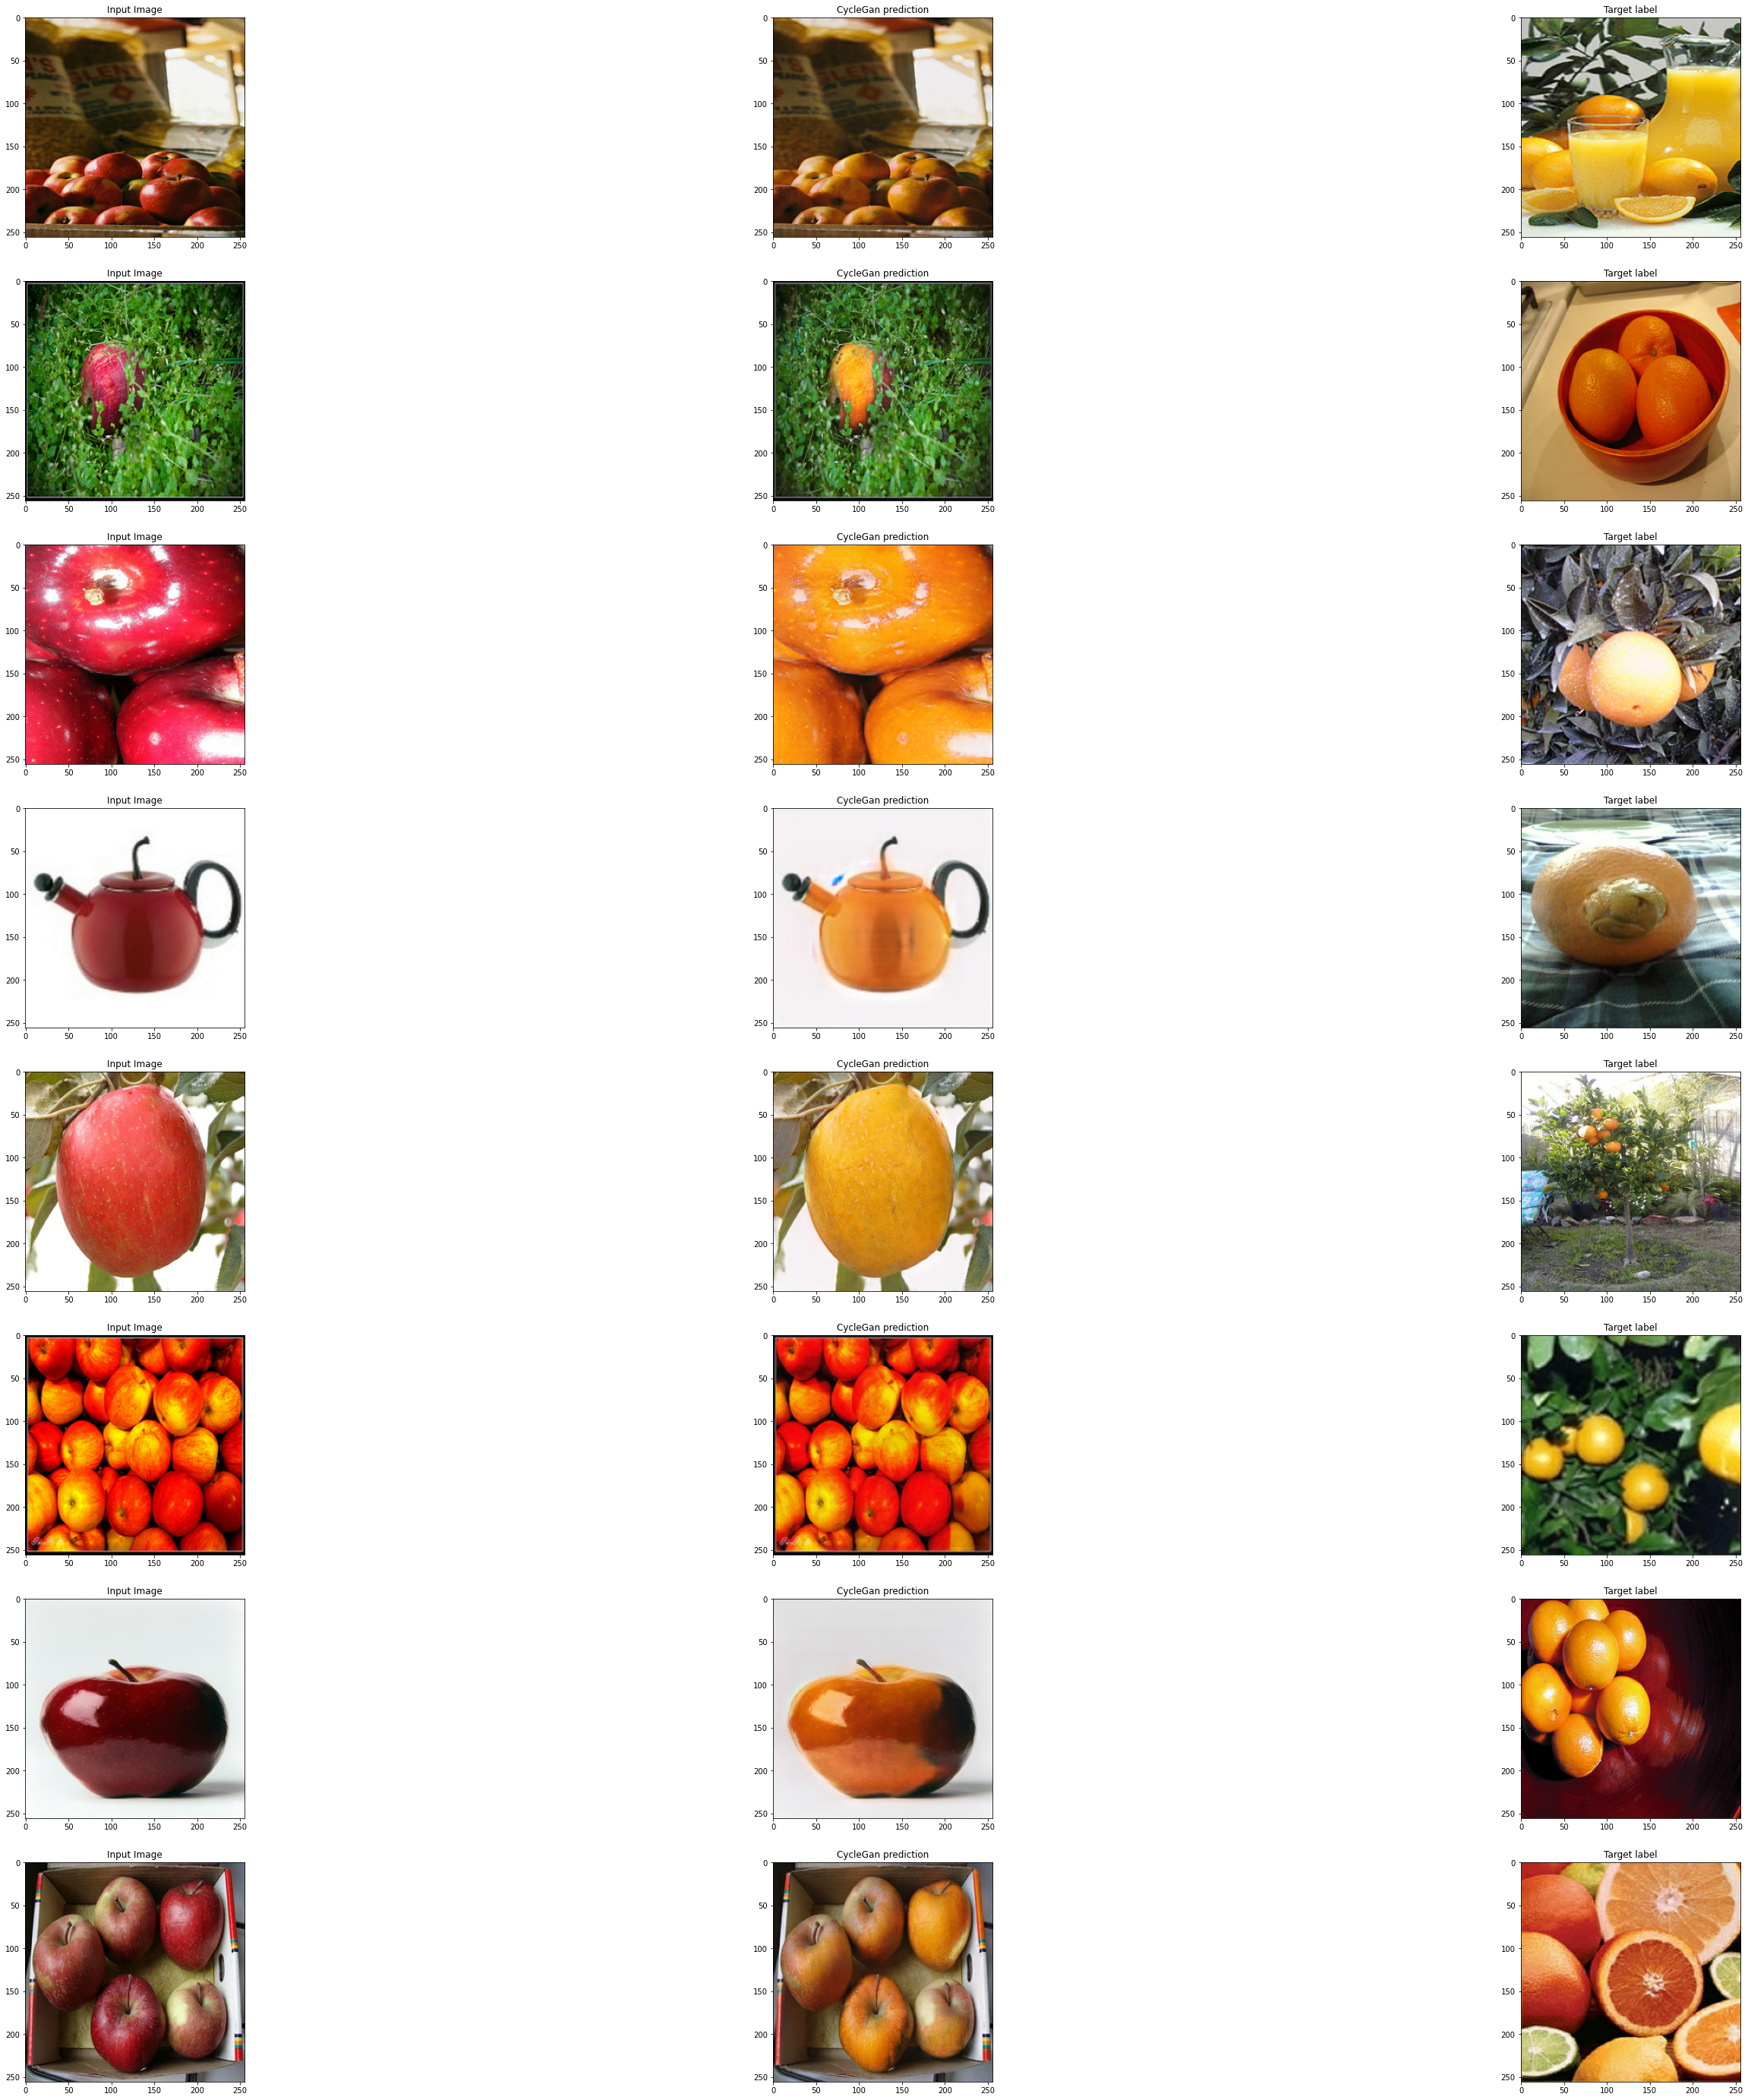

In [36]:
# plot the respective predictions
print("[INFO] plotting the CycleGan predictions...")
(fig, axes) = subplots(nrows=config.INFER_BATCH_SIZE, ncols=3,
    figsize=(50, 50))

# plot the predicted images 
for (ax, inp, pred, tar) in zip(axes, sampleInput,
    preds, sampleOutput):
    # plot the input mask image
    ax[0].imshow(array_to_img(inp))
    ax[0].set_title("Input Image")

    # plot the predicted CycleGan image
    ax[1].imshow(array_to_img(pred))
    ax[1].set_title("CycleGan prediction")

    # plot the ground truth
    ax[2].imshow(array_to_img(tar))
    ax[2].set_title("Target label")

# check whether output image directory exists
# if it doesn't then create it
if not os.path.exists(config.BASE_IMAGES_PATH):
    os.makedirs(config.BASE_IMAGES_PATH)

# serialize the results to disk
print("[INFO] saving the CycleGan predictions to disk...")
fig.savefig(config.GRID_IMAGE_PATH)

REFERENCES : 

Chandhok, S. “CycleGAN: Unpaired Image-to-Image Translation (Part 1),” PyImageSearch, P. Chugh, A. R. Gosthipaty, S. Huot, K. Kidriavsteva, R. Raha, and A. Thanki, eds., 2022, https://pyimg.co/7vh0s

Chandhok, S. “CycleGAN: Unpaired Image-to-Image Translation (Part 2),” PyImageSearch, P. Chugh, A. R. Gosthipaty, S. Huot, K. Kidriavsteva, R. Raha, and A. Thanki, eds., 2023, https://pyimg.co/jnael